# Imports and Data Loading

In [36]:
%reload_ext autoreload
%matplotlib inline 
import h5py
import numpy as np
import scipy 
import matplotlib.pyplot as plt
import pandas as pd
import os
from mpl_toolkits.mplot3d import Axes3D
from datetime import datetime

In [2]:
# Load data and display the sessions 
animal="FN" # "FN" or "WI" 
data_file = f"/Users/withercp/Documents/dev/brainhack/data/TH_task_{animal}_singleprobe_500ms.h5"
assert os.path.exists(data_file), "File not found: {data_file}".format(data_file=data_file)

with h5py.File(data_file, 'r') as f:
    sessions = list(f.keys())

In [72]:
i = 0

# Load data for a particular session and view the format of the data
session = sessions[i]
# convert mm-dd-yyyy to mm/dd/yyyy
date_str = session.replace('-', '/')

with h5py.File(data_file, 'r') as f:
    print(f[sessions[i]].keys())
    epoc_np=np.array(f[sessions[i]]['epoch'])
    rem_rec_np=np.array(f[sessions[i]]['rem_rec'])
    trial_np=np.array(f[sessions[i]]['trial'])
    binned_spike_np = np.array(f[sessions[i]]['binned_spike'])
    meta = np.array(f[sessions[i]]['meta'])

rem_rec_bin = np.array([1 if x == b'Remote' else 0 for x in rem_rec_np])

block_num = 0
block_nums = np.zeros(len(rem_rec_bin), dtype=int)  # Initialize array with zeros

for i in range(1, len(rem_rec_bin)):
    if rem_rec_bin[i] != rem_rec_bin[i-1]:  # If trial type changes
        block_num += 1  # Increment block number
    block_nums[i] = block_num  # Assign block number to current trial

unique_blocks = np.unique(block_nums)

<KeysViewHDF5 ['binned_spike', 'epoch', 'meta', 'rem_rec', 'trial']>


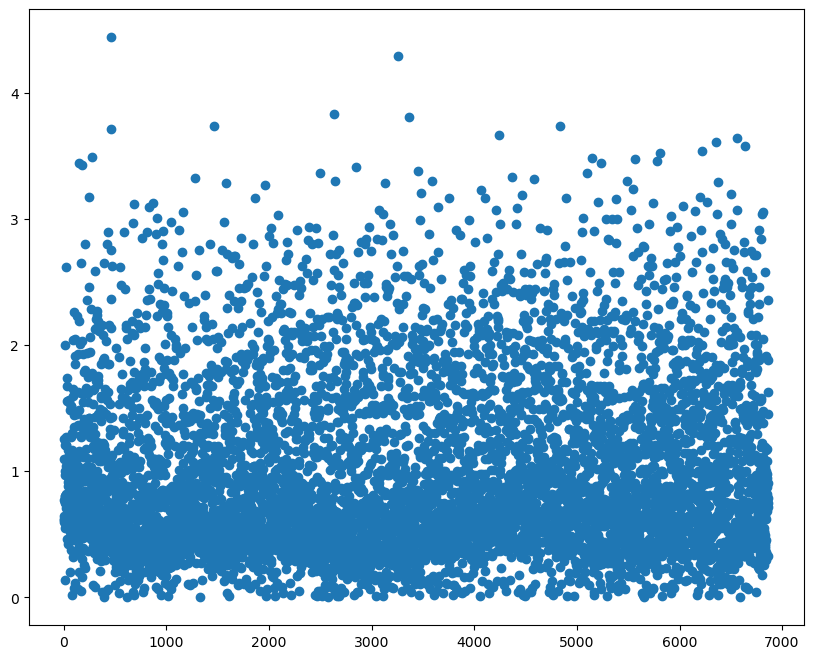

In [68]:
fig, ax = plt.subplots(figsize=(10,8))

x = np.arange(binned_spike_np.shape[1])
y = np.mean(binned_spike_np, axis=0)
ax.scatter(
    x,
    y,
)
plt.show()

In [ ]:
# # Get correct and incorrect trials per screen
# df = pd.read_csv(f"/Users/withercp/Documents/dev/brainhack/data/{animal}_TT_ALL_refined.csv")
# df = df[df['Date'] == date_str]
# print(df.head())

# screen_correct = np.zeros((4, df['TrialNum'].max()))
# screen_correct[0, :] = df["Correct"][::4]
# screen_correct[1, :] = df["Correct"][1::4]
# screen_correct[2, :] = df["Correct"][2::4]
# screen_correct[3, :] = df["Correct"][3::4]
# screen_correct_drift = screen_correct[:, :-1]

In [69]:
scipy.stats.pearsonr(x,y)

PearsonRResult(statistic=0.07471205956872294, pvalue=5.69210358894692e-10)

In [4]:
# Only keep rows where in at least one bin, the neuron fired at least 500 times 
# (i.e. the neuron is not active in that bin)

rows_to_keep = [] 
for i in unique_blocks:
    for j in range(binned_spike_np.shape[0]):
        if np.sum(binned_spike_np[j, block_nums == i]) >= 500:
            rows_to_keep.append(j)

rows_to_keep = np.unique(rows_to_keep)

binned_spike_np = binned_spike_np[rows_to_keep, :]

# Normalize binned spike data 
binned_spike_np_z = scipy.stats.zscore(binned_spike_np, axis=1)

# Classifier

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression

# Simple logistic regression classifier to predict behavior (classification) from low dimensional data (data)
def logistic_regression_classifier(data, classification):
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(data, classification, test_size=0.2, random_state=42)

    # Fit the model
    model = LogisticRegression()
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)

    # Calculate the accuracy
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy

# PCA

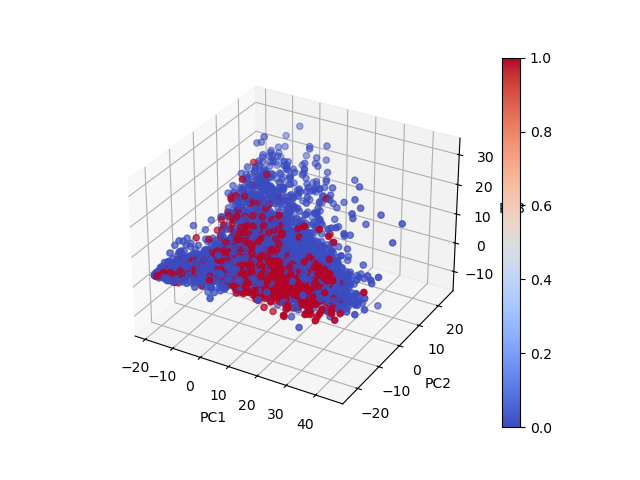

In [6]:
# PCA on all labels
from sklearn.decomposition import PCA

def PCA_binned_spike_np(X, y):
    pca = PCA(n_components=3)
    pca.fit(np.transpose(X))
    embedding = pca.transform(np.transpose(X))  # (n_times, n_components)

    # Plot PCA embedding and color by value in epoc_np
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    scatter = ax.scatter(embedding[:,0], embedding[:,1], embedding[:,2], c=y, cmap='coolwarm')
    plt.colorbar(scatter)
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    ax.set_zlabel('PC3')
    plt.show()
    return embedding

embedding = PCA_binned_spike_np(binned_spike_np, epoc_np==5)

In [7]:
logistic_regression_classifier(embedding, classification=epoc_np==5)

0.7911818738518065

# t-SNE

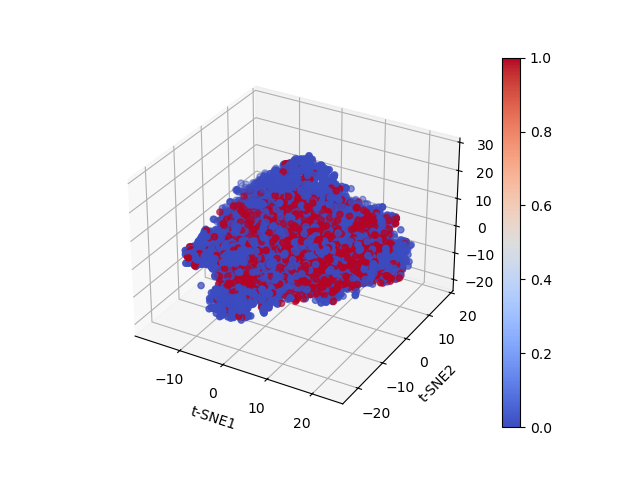

In [8]:
from sklearn.manifold import TSNE

def TSNE_binned_spike_np(X, y):
    # t-SNE
    tsne = TSNE(n_components=3, perplexity=50)
    embedding = tsne.fit_transform(np.transpose(X))

    # Plot the first three components in 3d and make the plot interactive
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    scatter = ax.scatter(embedding[:,0], embedding[:,1], embedding[:,2], c=y, cmap='coolwarm')
    plt.colorbar(scatter)
    ax.set_xlabel('t-SNE1')
    ax.set_ylabel('t-SNE2')
    ax.set_zlabel('t-SNE3')
    plt.show()

    return embedding

tsne_embedding = TSNE_binned_spike_np(binned_spike_np, epoc_np==5)

In [9]:
logistic_regression_classifier(tsne_embedding, classification=epoc_np==5)

0.810777709736681

# Tracking representations

In [16]:
epoc_np[:100]

array([1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1.5,
       1.5, 1.5, 1.5, 2. , 2. , 2. , 2. , 2. , 2. , 2. , 2. , 2. , 2.5,
       2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 3. , 3. , 3. , 3. , 3. , 3. ,
       3. , 3. , 3. , 3. , 3.5, 3.5, 4. , 4. , 4. , 4. , 4. , 4. , 4. ,
       4. , 4. , 4.5, 4.5, 4.5, 4.5, 4.5, 4.5, 4.5, 5. , 5. , 5. , 5. ,
       5. , 5. , 5. , 5. , 5. , 5. , 5. , 5. , 5. , 1. , 1. , 1. , 1. ,
       1. , 1. , 1. , 1. , 1. , 1.5, 1.5, 1.5, 1.5, 1.5, 2. , 2. , 2. ,
       2. , 2. , 2. , 2. , 2. , 2. , 2.5, 2.5, 2.5])

# UMAP

In [ ]:
# import umap
# import numpy as np
# import matplotlib.pyplot as plt
# from matplotlib.widgets import Slider
# from sklearn.preprocessing import StandardScaler

# def UMAP_neural(X = binned_spike_np, y = trial_np, params = {'n_dims':3, 'metric': 'euclidean', 'n_neighbors':200, 'min_dist':0.2, 'init': 'spectral'}): 
#     reducer = umap.UMAP(n_components=3, n_neighbors=params['n_neighbors'], min_dist=params['min_dist'], metric=params['metric'], init='spectral', random_state=42)
#     scaled_block_firing_rate = StandardScaler().fit_transform(np.transpose(X))
#     embedding = reducer.fit_transform(scaled_block_firing_rate)

#     fig = plt.figure()
#     ax = fig.add_subplot(111, projection='3d')
#     scatter_plot = ax.scatter(embedding[:,0], embedding[:,1], embedding[:,2], c = y, cmap='coolwarm')
#     ax.set_xlabel('UMAP1')
#     ax.set_ylabel('UMAP2')
#     ax.set_zlabel('UMAP3')
#     #fig.colorbar(scatter_plot, ax=ax)
#     plt.show()
#     return embedding

# umap_embedding = UMAP_neural()

In [ ]:
# logistic_regression_classifier(umap_embedding, classification=epoc_np==5)

# Optuna

In [ ]:
# # Use optuna (bayesian optimization) to find the best hyperparameters for t-SNE to maximize classification accuracy

# import optuna
# from sklearn.manifold import TSNE
# from sklearn.model_selection import cross_val_score


# X = binned_spike_np # neural data
# y = rem_rec_np # classification labels

# # Simple logistic regression classifier to predict behavior (classification) from low dimensional data (data)
# def logistic_regression_classifier(data, classification):
#     # Split the data into training and testing sets
#     X_train, X_test, y_train, y_test = train_test_split(data, classification, test_size=0.2, random_state=42)

#     # Fit the model
#     model = LogisticRegression()
#     model.fit(X_train, y_train)

#     # Make predictions
#     y_pred = model.predict(X_test)

#     # Calculate the accuracy
#     accuracy = accuracy_score(y_test, y_pred)
#     return accuracy

# # Define the objective function for Optuna
# def objective(trial):
#     # Define the t-SNE object with the hyperparameters to optimize
#     tsne = TSNE(
#         n_components=3,
#         perplexity=trial.suggest_int('perplexity', 5, len(y)-1),
#         learning_rate=trial.suggest_float('learning_rate', 10, 100),
#         n_iter=trial.suggest_int('n_iter', 250, 1000),
#         random_state=42
#     )

#     # Transform the data with t-SNE
#     tsne_embedding = tsne.fit_transform(np.transpose(X))
#     accuracy = logistic_regression_classifier(tsne_embedding, y)
#     return accuracy

# # Define the study object for Optuna
# study = optuna.create_study(direction='maximize')

# # Optimize the hyperparameters with Optuna
# study.optimize(objective, n_trials=3)

# # Print the best hyperparameters and score
# print("Best parameters: ", study.best_params)
# print("Best score: ", study.best_value)

# # Plot the t-SNE embedding with the best hyperparameters
# tsne = TSNE(
#     n_components=3,
#     perplexity=study.best_params['perplexity'],
#     learning_rate=study.best_params['learning_rate'],
#     n_iter=study.best_params['n_iter'],
#     random_state=42
# )
# tsne_embedding = tsne.fit_transform(np.transpose(X))

# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
# ax.scatter(tsne_embedding[:,0], tsne_embedding[:,1], tsne_embedding[:,2], c=trial_np, cmap='jet')
# ax.set_xlabel('t-SNE1')
# ax.set_ylabel('t-SNE2')
# ax.set_zlabel('t-SNE3')
# ax.set_title('t-SNE on Block Segment (Firing Rate)')

# clf = LogisticRegression(random_state=0)
# score = cross_val_score(clf, tsne_embedding, y, cv=5).mean()
# print("Classification accuracy for remote/recent:", score)

In [ ]:
# # Use optuna (bayesian optimization) to find the best hyperparameters for UMAP to maximize classification accuracy 

# import optuna
# from umap import UMAP
# from sklearn.linear_model import LogisticRegression
# from sklearn.model_selection import cross_val_score
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import accuracy_score
# from sklearn.neighbors import KNeighborsClassifier

# X = binned_spike_np
# y = rem_rec_np

# def logistic_regression_classifier(data, classification):
#     X_train, X_test, y_train, y_test = train_test_split(data, classification, test_size=0.2, random_state=42)
#     model = LogisticRegression()
#     model.fit(X_train, y_train)
#     y_pred = model.predict(X_test)
#     accuracy = accuracy_score(y_test, y_pred)
#     return accuracy


# def objective(trial):
#     umap = UMAP(
#         n_components=3,
#         n_neighbors=trial.suggest_int('n_neighbors', 100, len(y)-1),
#         min_dist=trial.suggest_float('min_dist', 0.01, 1),
#         spread=trial.suggest_float('spread', 1.0, 1.5),
#         metric=trial.suggest_categorical('metric', ['cosine', 'euclidean']), 
#     )
#     umap_embedding = umap.fit_transform(np.transpose(X))
#     #accuracy = logistic_regression_classifier(umap_embedding, y)
#     accuracy = logistic_regression_classifier(umap_embedding)
#     return accuracy

# study = optuna.create_study(direction='maximize')
# study.optimize(objective, n_trials=20)

# print("Best parameters: ", study.best_params)
# print("Best score: ", study.best_value)

# umap = UMAP(
#     n_components=3,
#     n_neighbors=study.best_params['n_neighbors'],
#     min_dist=study.best_params['min_dist'],
#     spread=study.best_params['spread']
# )
# umap_embedding = umap.fit_transform(np.transpose(X))

# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
# ax.scatter(umap_embedding[:,0], umap_embedding[:,1], umap_embedding[:,2], c=y, cmap='jet')
# ax.set_xlabel('UMAP1')
# ax.set_ylabel('UMAP2')
# ax.set_zlabel('UMAP3')
# ax.set_title('UMAP (Firing Rate)')

# clf = LogisticRegression(random_state=0)
# score = cross_val_score(clf, umap_embedding, y, cv=5).mean()
# print("Classification accuracy for remote/recent:", score)